In [1]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import re as re
import os
import copy
import statsmodels.formula.api as sm
import pymc3 as pm
import matplotlib.pyplot as plt

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Yurii\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
conflict = pd.read_csv('Data\\conflict_data\\DRC_2.csv', header = 0, index_col = 0)

aid = pd.read_csv('Data\\aid_data\\data\\level_1a.csv')
aid = aid.dropna(subset=['latitude', 'longitude', 'transactions_start_year']) # drop those entries that don't have coordinates and start year to them
#aid = aid.drop(aid[aid['transactions_start_year'] == ' '].index) # some projects don't have start year, so we drop those rows
aid = aid.drop(aid[aid['even_split_commitments'].isnull()].index) # some projects don't have info on commitments, so we drop those rows
aid['transactions_start_year'] = pd.to_numeric(aid['transactions_start_year'])

worker_deaths = pd.read_csv('Data\\security_incidents.csv', encoding = "ISO-8859-1")

provinces = gpd.read_file('Data\\gadm36_COD_shp/gadm36_COD_1.shp')

In [133]:
geometry = [Point(xy) for xy in zip(conflict.longitude, conflict.latitude)]
gconflict = gpd.GeoDataFrame(conflict, crs = {'init': 'epsg:4326'}, geometry = geometry)

geometry = [Point(xy) for xy in zip(aid.longitude, aid.latitude)]
gaid = gpd.GeoDataFrame(aid, crs = {'init': 'epsg:4326'}, geometry = geometry)

geometry = [Point(xy) for xy in zip(worker_deaths.Longitude, worker_deaths.Latitude)]
g_w_d = gpd.GeoDataFrame(worker_deaths, crs = {'init': 'epsg:4326'}, geometry = geometry) # g_w_d = gworker_deaths


gconflict = gpd.sjoin(gconflict, provinces, how="inner")
gaid = gpd.sjoin(gaid, provinces, how="inner")
g_w_d = gpd.sjoin(g_w_d, provinces, how="inner")

# rename the column regarding the start year so that it corresponds to the name in casualties dataset
gaid = gaid.rename(columns = {'even_split_commitments': 'commitments', 'transactions_start_year': 'year'})

In [134]:
def plot_distances(year):
    min_dists = []
    for aid_project in gaid[gaid['transactions_start_year'] == year]['geometry']:
        min_dists.append(min(gconflict[gconflict['year'] == year + 1]['geometry'].distance(aid_project)))
    
    min_dists = pd.Series(min_dists) * 110
    
    #min_dists.plot.density()
    
    #plt.show()
    #print(min_dists.mean())
    #print(min_dists.median())
    return min_dists

In [11]:
distances = pd.Series()

for year in range(2000, 2014):
    try:  
        distances = distances.append(plot_distances(year))
    except:
        print(year)
        continue

#plt.show()

In [12]:
fig = plt.figure(figsize = (15, 15))
distances.plot.density()

plt.axvline(distances.mean(), color = 'r', linestyle = '--')
plt.text(distances.mean()+20,0.002,'mean = %i' % (distances.mean()), rotation=90, fontsize=20)

plt.axvline(distances.median(), color = 'orange', linestyle = '--')
plt.text(distances.median() + 5,0.002,'median %i' % (distances.median()),rotation=90, fontsize=20)
plt.savefig('Graphs\\NN_distance_DRC.png', bbox_inches='tight')

In [135]:
# calculate the number of rows there column_name has more than one entry, separated by "|". We use this for donors and aid focus. 
def calc_multiples(df, column_name):
    s = 0
    l = []
    for index, row in df.iterrows():
        entries = row[column_name].split("|")
        if len(entries) > 1:
            s += 1
            l.append(index)
    return s#, l

# split those rows that have more than one entry in a certain column name.
# We create a new row for each of the multiple entries (other entries being the same)
# and delete the original multiple entry row. 
def split_rows(data, column_name):
    df = copy.deepcopy(data)
    temp = pd.DataFrame()
    for index, row in df.iterrows():
        entries = row[column_name].split("|")
        if len(entries) > 1:
            for entry in entries:
                temp_row = row
                temp_row[column_name] = entry
                temp = temp.append(temp_row)
            df.drop(index, inplace = True)
            
    return df.append(temp)

# split the rows(projects) that have more than one donor per project
gaid = split_rows(gaid, 'donors')
gaid = split_rows(gaid, 'ad_sector_names')

In [136]:
if not os.path.exists('measures_indices'):
    os.makedirs('measures_indices')
    
# how many projects there are per donor and their share in the total, save in a csv file  
total = gaid['donors'].value_counts() # total N of projects per donor
share = gaid['donors'].value_counts() / gaid.shape[0] # calculate share of the projects per donor in total N of projects
pd.concat([total, share], axis = 1).to_csv('measures_indices\\N_projects_per_donor.csv')

# what share of projects per donor have multiple focus sectors (e.g. General environmental protection|Transport and storage)
multiple_focus_share = (gaid.groupby('donors').apply(calc_multiples, 'ad_sector_names') / gaid['donors'].value_counts())
multiple_focus_share.to_csv('measures_indices\\project_multiple_sectors.csv')

# share of each project focus in the total number of projects per donor. We use this to calculate variablity of project focus for a donor
focus_share = (gaid.groupby(['donors', 'ad_sector_names']).size() / gaid.groupby(['donors']).size())
focus_share.to_csv('measures_indices\\donor_sector_share.csv')

In [137]:
# Func calculates the coefficient of unalikeability (as defined by Kader 2007) of every sublcass of first_group variable by topic_name
# E.g. unalikeability of project location for each aid donor -> calc_unalikeability(gaid, 'donors', 'ad_sector_names')

def calc_unalikeability(data, first_group, topic_name):
    
    # prepare data: group by first_group and topic_name, and divide by the size of the respective group
    # thus we obtain the share that each topic_name has in the respective first_group
    
    d = (data.groupby([first_group, topic_name]).size() / gaid.groupby([first_group]).size())
    
    # here we get the keys for the first level grouping. So, the unique values of first group column
    keys = []
    for i in d.index:
        keys.append(i[0])
    keys = set(keys)
    
    # here we calculate the actual coefficient
    # for every value of first_group we calculate its coefficient:
    # coefficient is defined as 1 - SUM_i(p_i^2), where p_i is the share of the ith subgroup in the total group. 
    
    coefs = {}
    for key in keys:
        s = 0
        for subgroup in d[key]:
            s += subgroup ** 2
        coef = 1 - s
        coefs[key] = coef
    return pd.Series(coefs)


# calculates the variablity of topic_name (e.g. total commitments of money) for every member of first_group
def calc_var(data, first_group, topic_name):
    d = data.groupby(first_group)
    
    def var(d):
        d = d[topic_name]
        d = (d - min(d)) / (max(d) - min(d))
        
        if np.isnan(np.var(d)):
            return 0
        
        return np.var(d)
    
    return d.apply(var)

In [138]:
adaptability_by_focus = calc_unalikeability(gaid, 'donors', 'ad_sector_names')
adaptability_by_location =calc_unalikeability(gaid, 'donors', 'NAME_1')
adaptability_by_start_year = calc_unalikeability(gaid, 'donors', 'year')
adaptability_by_commitment = calc_var(gaid, 'donors', 'total_commitments')
composite_adaptability = adaptability_by_commitment + adaptability_by_start_year + adaptability_by_location + adaptability_by_focus
#pd.DataFrame.from_dict(adaptability_by_focus, orient = 'index').to_csv('measures_indices\\adaptability_by_focus.csv')
#pd.DataFrame.from_dict(adaptability_by_location, orient = 'index').to_csv('measures_indices\\adaptability_by_location.csv')
#pd.DataFrame.from_dict(adaptability_by_start_year, orient = 'index').to_csv('measures_indices\\adaptability_by_start_year.csv')
#adaptability_by_commitment.to_csv('measures_indices\\adaptability_by_commitments.csv')
#(composite_adaptability).to_csv('measures_indices\\composite_adaptability.csv')

In [139]:
# Divide donors into 2 groups: higly adaptable and not higly adaptable, the division line is the median. 
median = composite_adaptability.median()
high_adaptability = composite_adaptability[composite_adaptability >= median]
low_adaptability = composite_adaptability[composite_adaptability < median]

In [140]:
# Compute the year, ADM1 pairs of events when aid workers were killed. 
# Then, we can assume that these are unreceptive year, region pairs.
# However, we can also divide this into 2 subgroups: more than average (or median) casualties vs less than average (or median) casualties
worker_deaths_grouped = g_w_d.groupby(['Year', 'NAME_1'])['Total affected'].sum()
worker_deaths_grouped.to_csv('measures_indices\\year_location_pairs.csv')

# The idea is that low_receptivity is depcited by a lot of worker deaths
# high receptivity is depicted by a lesser number of worker deaths

#low_receptivity = worker_deaths_grouped > worker_deaths_grouped.describe()['mean']
#high_receptivity = worker_deaths_grouped < worker_deaths_grouped.describe()['mean']

low_receptivity = worker_deaths_grouped > 0
high_receptivity = worker_deaths_grouped == 0

In [141]:
# custom function to check whether a tuple is included in an array of tuples (for some reason, basic function did not work)
def check_in (tupl, array):
    for element in array:
        if (tupl[0] == element[0]) & (tupl[1] == element[1]):
            return True

# select those row numbers (indices) of gaid dataframe that represent projects that started in the same year/adm1 combination
# as highly receptive ones
low_receptive_indices = []

low_receptive = pd.DataFrame()
highly_receptive = pd.DataFrame()

for index, row in gaid.iterrows():
    tupl = (int(row['year']), row['NAME_1'])
    if check_in(tupl, worker_deaths_grouped[low_receptivity].index.values):
        low_receptive_indices.append(index)
        low_receptive = low_receptive.append(row)
    else:
        highly_receptive = highly_receptive.append(row)

        
# select projects that are created in higly receptive and low receptive year/adm1 combinations 

#low_receptive = gaid.loc[low_receptive_indices]
#highly_receptive = gaid.loc[~gaid.index.isin(low_receptive_indices)]

#low_receptive = gaid.loc[~gaid.index.isin(high_receptive_indices)]
#highly_receptive = gaid.iloc[high_receptive_indices]

In [142]:
# High receptivity + high adaptability indices
high_receptivity_high_adaptability = highly_receptive[highly_receptive['donors'].isin(high_adaptability.index)]
high_receptivity_low_adaptability = highly_receptive[highly_receptive['donors'].isin(low_adaptability.index)]

low_receptivity_high_adaptability = low_receptive[low_receptive['donors'].isin(high_adaptability.index)]
low_receptivity_low_adaptability = low_receptive[low_receptive['donors'].isin(low_adaptability.index)]

In [143]:
region_year_casualties = gconflict[['year', 'NAME_1', 'best_est']].groupby(['NAME_1', 'year']).sum()
region_year_aid = gaid[['year', 'NAME_1', 'commitments']].groupby(['NAME_1', 'year']).sum()

In [47]:
def add_lag(df, column_name, new_name):
    output = pd.DataFrame()
    df[new_name] = df.groupby(level = 0)[column_name].shift(1)
    by_country = df.groupby(level = 0)
    for name, group in by_country:
        country = group.reset_index()
        last_row = country.iloc[-1, :]
        temp = copy.deepcopy(last_row)
        temp['year'] += 1
        temp[new_name] = temp[column_name]
        temp[column_name] = np.nan
    
        country = country.append(temp, ignore_index = True)
        output = output.append(country)
    return output

In [145]:
# add the lag variable (for a (district, year) pair (d, t) , we are looking at commitments on (d, t-1). This action also resets hierachical index
region_year_aid = add_lag(region_year_aid, 'commitments', 'lagged_commitments')

# reset the hierachical index, so that the dataframe obtain the same structure
region_year_casualties = add_lag(region_year_casualties, 'best_est', 'lagged_casualties')

In [146]:
region_year_aid['commitments_difference'] = region_year_aid['commitments'] - region_year_aid['lagged_commitments']
region_year_aid['log_commitments'] = np.log(region_year_aid['commitments'] )
region_year_aid['log_lagged_commitments'] = np.log(region_year_aid['lagged_commitments'] )
region_year_aid['log_difference'] = np.log(region_year_aid['commitments_difference'] )
region_year_aid['difference_of_logs'] = region_year_aid['log_commitments'] - region_year_aid['log_lagged_commitments']

region_year_casualties['casulaties_difference'] = region_year_casualties['best_est'] - region_year_casualties['lagged_casualties']
region_year_casualties['casulaties_log'] = np.log(region_year_casualties['best_est'])
#region_year_casualties['casulaties_log'] = np.log(region_year_casualties['best_est'])
region_year_casualties['casulaties_standardized'] = (region_year_casualties['best_est'] - np.mean(region_year_casualties['best_est'])) / np.var(region_year_casualties['best_est'])
region_year_casualties['lagged_casualties_standardized'] = (region_year_casualties['lagged_casualties'] - np.mean(region_year_casualties['lagged_casualties'])) / np.var(region_year_casualties['lagged_casualties'])

In [147]:
aid_and_conflict = pd.merge(region_year_aid, region_year_casualties, on = ['NAME_1', 'year'])

In [152]:
result = sm.ols(formula = 'casulaties_standardized ~ log_lagged_commitments', data = aid_and_conflict).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     casulaties_standardized   R-squared:                       0.041
Model:                                 OLS   Adj. R-squared:                  0.027
Method:                      Least Squares   F-statistic:                     2.921
Date:                     Mon, 16 Jul 2018   Prob (F-statistic):             0.0919
Time:                             21:43:41   Log-Likelihood:                 520.09
No. Observations:                       71   AIC:                            -1036.
Df Residuals:                           69   BIC:                            -1032.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.0005      0.000     -2.100      0.039      -0.001   -2.31e-05
log_lagged_commitments  2.219e-05    1.3e-05      1.709      0.092   -3.71e-06    4.81e-05
==============================================================================
Omnibus:                       83.972   Durbin-Watson:                   1.217
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              828.151
Skew:                           3.650   Prob(JB):                    1.48e-180
Kurtosis:                      18.055   Cond. No.                         193.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [156]:
four_groups = {'HR_LA': high_receptivity_low_adaptability,
               'LR_HA': low_receptivity_high_adaptability,
               'LR_LA': low_receptivity_low_adaptability,
               'HR_HA': high_receptivity_high_adaptability}


def estimate_relationship(aid_group):
    region_year_aid = aid_group[['year', 'NAME_1', 'commitments']].groupby(['NAME_1', 'year']).sum()

    region_year_aid = add_lag(region_year_aid, 'commitments', 'lagged_commitments')

    region_year_aid['commitments_difference'] = region_year_aid['commitments'] - region_year_aid['lagged_commitments']
    region_year_aid['log_commitments'] = np.log(region_year_aid['commitments'] )
    region_year_aid['log_lagged_commitments'] = np.log(region_year_aid['lagged_commitments'] )
    region_year_aid['log_difference'] = np.log(region_year_aid['commitments_difference'] )
    region_year_aid['difference_of_logs'] = region_year_aid['log_commitments'] - region_year_aid['log_lagged_commitments']

    aid_and_conflict = pd.merge(region_year_aid, region_year_casualties, on = ['NAME_1', 'year'])

    result = sm.ols(formula = 'casulaties_standardized ~ log_lagged_commitments', data = aid_and_conflict).fit()
    print(result.summary())
    



for key, value in four_groups.items():
    print('CURRENT GROUP ', key)
    estimate_relationship(value)

CURRENT GROUP  HR_LA
                               OLS Regression Results                              
Dep. Variable:     casulaties_standardized   R-squared:                       0.025
Model:                                 OLS   Adj. R-squared:                 -0.026
Method:                      Least Squares   F-statistic:                    0.4925
Date:                     Mon, 16 Jul 2018   Prob (F-statistic):              0.491
Time:                             22:03:24   Log-Likelihood:                 174.55
No. Observations:                       21   AIC:                            -345.1
Df Residuals:                           19   BIC:                            -343.0
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

C:\Users\Yurii\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


                               OLS Regression Results                              
Dep. Variable:     casulaties_standardized   R-squared:                       0.006
Model:                                 OLS   Adj. R-squared:                 -0.070
Method:                      Least Squares   F-statistic:                   0.08051
Date:                     Mon, 16 Jul 2018   Prob (F-statistic):              0.781
Time:                             22:03:24   Log-Likelihood:                 101.46
No. Observations:                       15   AIC:                            -198.9
Df Residuals:                           13   BIC:                            -197.5
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

C:\Users\Yurii\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


                               OLS Regression Results                              
Dep. Variable:     casulaties_standardized   R-squared:                       0.062
Model:                                 OLS   Adj. R-squared:                 -0.042
Method:                      Least Squares   F-statistic:                    0.5969
Date:                     Mon, 16 Jul 2018   Prob (F-statistic):              0.460
Time:                             22:03:24   Log-Likelihood:                 78.463
No. Observations:                       11   AIC:                            -152.9
Df Residuals:                            9   BIC:                            -152.1
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [158]:
import pymc3 as pm
formula = 'casulaties_standardized ~ log_lagged_commitments'

with pm.Model() as normal_model:
    
    # The prior for the data likelihood is a Normal Distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = aid_and_conflict, family = family)
    
    # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 1500, njobs=-1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
 24%|██████████████████▉                                                            | 841/3500 [02:47<08:50,  5.01it/s]C:\Users\Yurii\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Only one chain was sampled, this makes it impossible to run some convergence checks


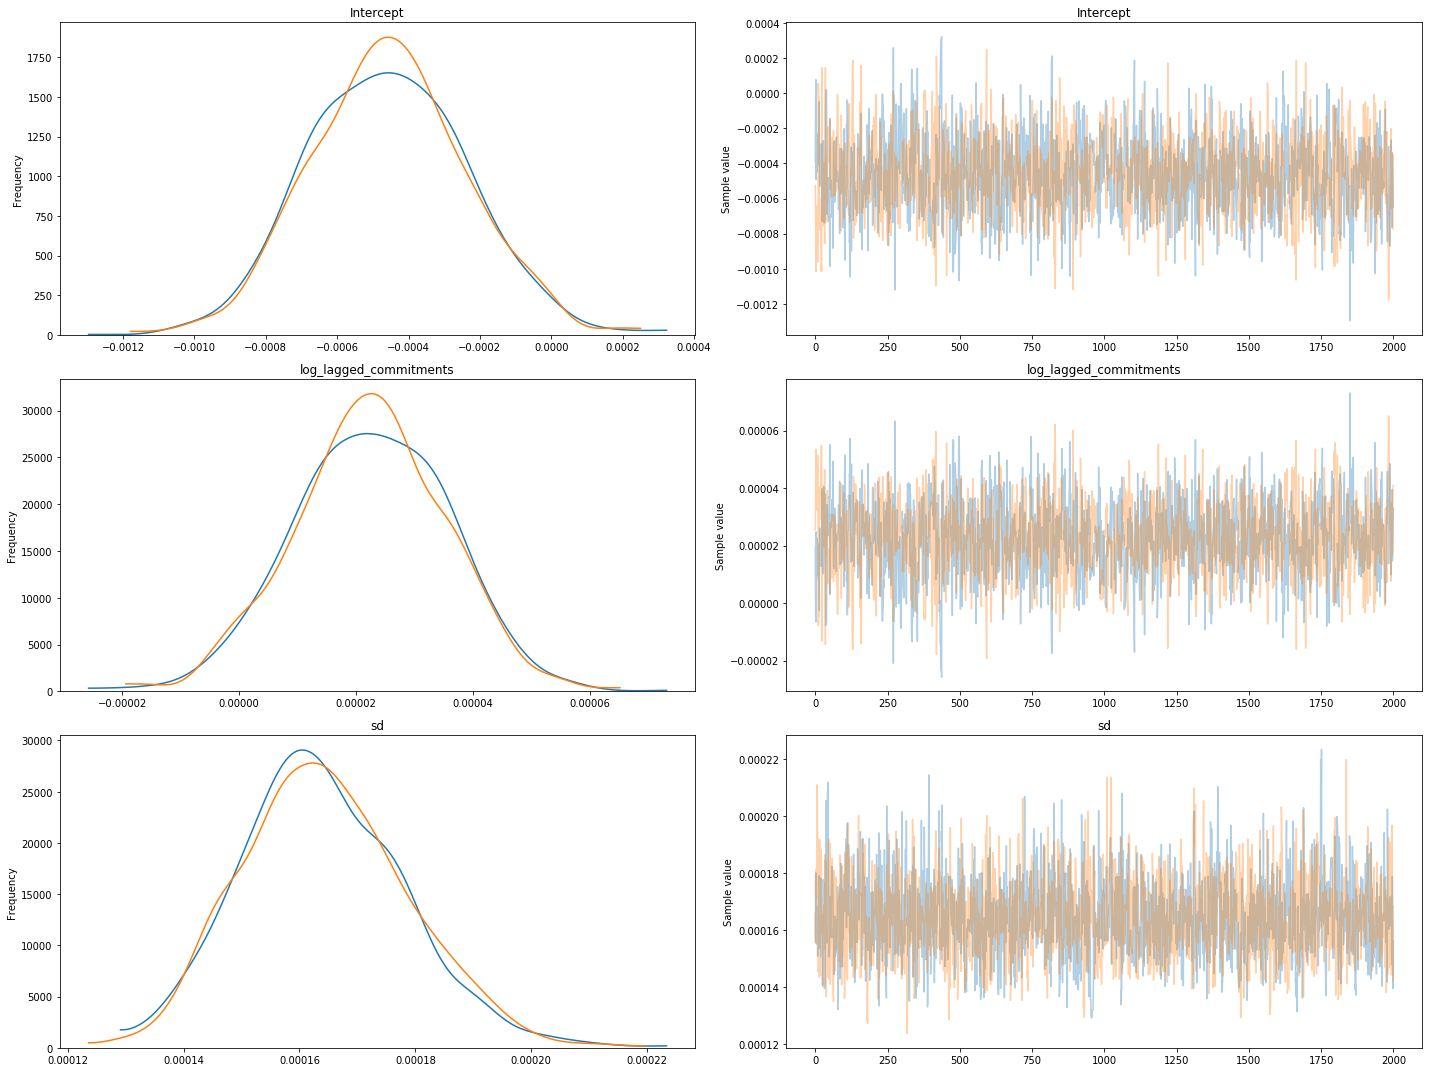

In [74]:
pm.traceplot(normal_trace, figsize = (20, 15))
plt.savefig('Graphs\\traceplot.png')
plt.show()

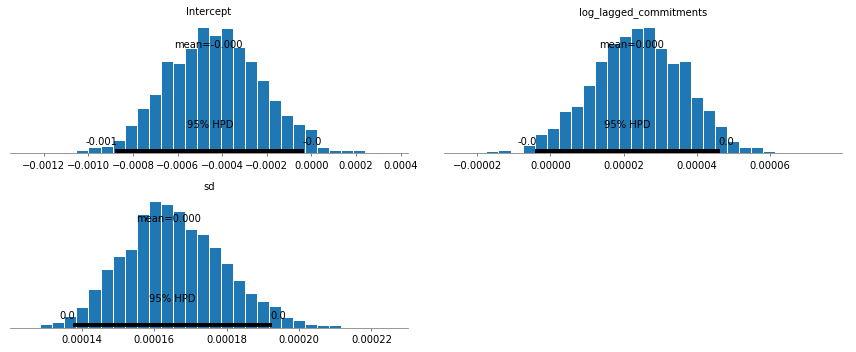

In [75]:
pm.plot_posterior(normal_trace)
plt.show()

In [76]:
pm.summary(normal_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-0.000462,0.000218,5.487862e-06,-0.000870,-0.000041,1349.697908,0.999817
log_lagged_commitments,0.000022,0.000013,3.243691e-07,-0.000004,0.000046,1356.757573,0.999809
sd,0.000164,0.000014,3.312333e-07,0.000138,0.000192,1517.574627,0.999943


In [161]:
formula = 'casulaties_standardized ~ log_lagged_commitments'

def estimate_relationship_bayesian(group_name, aid_group):
    region_year_aid = aid_group[['year', 'NAME_1', 'commitments']].groupby(['NAME_1', 'year']).sum()

    region_year_aid = add_lag(region_year_aid, 'commitments', 'lagged_commitments')

    region_year_aid['commitments_difference'] = region_year_aid['commitments'] - region_year_aid['lagged_commitments']
    region_year_aid['log_commitments'] = np.log(region_year_aid['commitments'] )
    region_year_aid['log_lagged_commitments'] = np.log(region_year_aid['lagged_commitments'] )
    region_year_aid['log_difference'] = np.log(region_year_aid['commitments_difference'] )
    region_year_aid['difference_of_logs'] = region_year_aid['log_commitments'] - region_year_aid['log_lagged_commitments']

    aid_and_conflict = pd.merge(region_year_aid, region_year_casualties, on = ['NAME_1', 'year'])

    with pm.Model() as normal_model:

        # The prior for the data likelihood is a Normal Distribution
        family = pm.glm.families.Normal()

        # Creating the model requires a formula and data (and optionally a family)
        pm.GLM.from_formula(formula, data = aid_and_conflict, family = family)

        # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
        normal_trace = pm.sample(draws=1500, chains = 2, tune = 1000, njobs=-1)
        
    print(pm.summary(normal_trace))

    pm.traceplot(normal_trace, figsize = (20, 15))
    plt.savefig('Graphs\\traceplot_%s.png' % (group_name))
    
for key, value in four_groups.items():
    print(key)
    estimate_relationship_bayesian(key, value)

HR_LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [04:14<00:00,  9.82it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.879922486308, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


                            mean        sd      mc_error   hpd_2.5  hpd_97.5  \
Intercept              -0.000220  0.000148  5.056825e-06 -0.000508  0.000075   
log_lagged_commitments  0.000006  0.000009  3.226565e-07 -0.000013  0.000025   
sd                      0.000067  0.000012  3.496307e-07  0.000047  0.000090   

                              n_eff      Rhat  
Intercept                738.086774  0.999687  
log_lagged_commitments   739.300625  0.999673  
sd                      1103.198482  1.003556  
LR_HA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [04:05<00:00, 10.19it/s]
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6365261897, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


                            mean        sd  mc_error   hpd_2.5  hpd_97.5  \
Intercept              -0.000386  0.001696  0.000077 -0.003950  0.002831   
log_lagged_commitments  0.000025  0.000095  0.000004 -0.000169  0.000210   
sd                      0.000334  0.000078  0.000004  0.000215  0.000480   

                             n_eff      Rhat  
Intercept               399.703251  1.009739  
log_lagged_commitments  400.796711  1.009315  
sd                      156.165441  1.004695  
LR_LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:38<00:00, 25.42it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


                            mean        sd  mc_error   hpd_2.5  hpd_97.5  \
Intercept              -0.000290  0.000490  0.000018 -0.001311  0.000584   
log_lagged_commitments  0.000020  0.000034  0.000001 -0.000045  0.000084   
sd                      0.000256  0.000102  0.000004  0.000140  0.000396   

                             n_eff      Rhat  
Intercept               560.507429  1.001238  
log_lagged_commitments  580.592427  1.001049  
sd                      530.053059  1.000267  
HR_HA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [06:01<00:00,  6.91it/s]


                            mean        sd      mc_error   hpd_2.5  hpd_97.5  \
Intercept              -0.000251  0.000184  6.246346e-06 -0.000605  0.000115   
log_lagged_commitments  0.000008  0.000011  3.805474e-07 -0.000012  0.000031   
sd                      0.000112  0.000011  2.603802e-07  0.000093  0.000134   

                              n_eff      Rhat  
Intercept                803.434289  1.000236  
log_lagged_commitments   793.903087  1.000238  
sd                      1422.131846  1.002440  


In [ ]:
# TODO LIST

# 3. Select projects based on the 4 subcategories derived above.
# Projects with: donor is in one of the first classification group.
# Start year and area is in one of the second classification groups.

#                        High adaptability              Low adaptability
#
# High receptivity           n                                 n2
#
# Low receptivity            n3                                n4



# 4. THINK ABOUT INFERENCE PROBLEM, MATCHING PROBLEM, CREATING CONTROL AND TREATMENT GROUPS.

In [2]:
drc = pd.read_excel('Data\\south_of_sahara\\DRC_Conflict_27June2012.xlsx', header = 0, index_col = 0)
uganda = pd.read_excel('Data\\south_of_sahara\\Uganda_Conflict_27June2012.xlsx', header = 0, index_col = 0)
ethiopia = pd.read_excel('Data\\south_of_sahara\\Ethiopia_Conflict_27June2012.xlsx', header = 0, index_col = 0)
sudan = pd.read_excel('Data\\south_of_sahara\\Sudan_Conflict_27June2012.xlsx', header = 0, index_col = 0)
burundi = pd.read_excel('Data\\south_of_sahara\\Burundi_Conflict_20June2012.xlsx', header = 0, index_col = 0)

ethiopia.drop(ethiopia[ethiopia['precision'] == '.'].index, inplace = True)
burundi.drop(burundi[burundi['precision'] == '        .'].index, inplace = True)

all_provinces = gpd.read_file('Data\\Shapefiles\\ADM1\\compiled.shp')

drc = drc[drc['precision'] <=6]
uganda = uganda[uganda['precision'] <=6]
ethiopia = ethiopia[ethiopia['precision'] <=6]
sudan = sudan[sudan['precision'] <=6]
burundi = burundi[burundi['precision'] <=6]

In [3]:
def recode_commitments(df):
    """
        Commitments are coded for for all locations within a project. 
        To arrive at an average per location divide the value over numbloc
    """
    df['usdcr'] = df['usdcr'] / df['numbloc']
    df['usdco'] = df['usdco'] / df['numbloc']
    return df

def geocode(df):
    geometry = [Point(xy) for xy in zip(df.long, df.lat)]
    gdf = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'}, geometry = geometry)
    gaid = gpd.sjoin(gdf, all_provinces, how="inner")
    return gaid

In [4]:
countries = [drc, uganda, ethiopia, sudan, burundi]
geoaid = [geocode(country) for country in countries]
geoaid = list(map(recode_commitments, geoaid))

geoaid_df = pd.DataFrame()
for country in geoaid:
    geoaid_df = geoaid_df.append(country)

In [15]:
burundi['usdco'].max()

46855903.0

In [48]:
def add_lag(df, column_name, new_name):
    output = pd.DataFrame()
    df[new_name] = df.groupby(level = 0)[column_name].shift(1)
    by_country = df.groupby(level = 0)
    for name, group in by_country:
        country = group.reset_index()
        last_row = country.iloc[-1, :]
        temp = copy.deepcopy(last_row)
        temp['year'] += 1
        temp[new_name] = temp[column_name]
        temp[column_name] = np.nan

        country = country.append(temp, ignore_index = True)
        output = output.append(country)
    return output

In [8]:
lagged_geoaid = pd.DataFrame()
for country in geoaid:
    lagged_geoaid = lagged_geoaid.append(add_lag(country[['year', 'NAME_1', 'usdcr']].groupby(['NAME_1', 'year']).sum(), 'usdcr', 'usdcr_lagged'))

lagged_geoaid = lagged_geoaid[lagged_geoaid['year'] >= 1999]

In [52]:
aggregate_conflict = pd.read_csv('Data\\conflict_data\\gedevents-2018-07-13.csv', header = 0, index_col = 0)
geometry = [Point(xy) for xy in zip(aggredate_conflict.longitude, aggredate_conflict.latitude)]
aggregate_conflict = gpd.GeoDataFrame(aggredate_conflict, crs = {'init': 'epsg:4326'}, geometry = geometry)

In [53]:
temp = pd.DataFrame()
aggregate_conflict = gpd.sjoin(aggregate_conflict, all_provinces, how = 'inner')

In [54]:
aggregate_conflict = aggregate_conflict.drop(aggregate_conflict[aggregate_conflict['NAME_1'].isnull()].index)
aggregate_region_year_casualties = aggregate_conflict[['year', 'NAME_1', 'best_est']].groupby(['NAME_1', 'year']).sum()
aggregate_region_year_casualties  = add_lag(aggregate_region_year_casualties, 'best_est', 'lagged_casualty')

In [56]:
aid_and_conflict = pd.merge(aggregate_region_year_casualties, lagged_geoaid, on = ['NAME_1', 'year'])

In [57]:
aid_and_conflict['lagged_commitments'] = np.log(aid_and_conflict['usdcr_lagged'])

In [60]:
result = sm.ols(formula = 'best_est ~ lagged_casualty + lagged_commitments', data = aid_and_conflict).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               best_est   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     51.40
Date:                Sun, 29 Jul 2018   Prob (F-statistic):           1.68e-20
Time:                        02:22:32   Log-Likelihood:                -2847.5
No. Observations:                 386   AIC:                             5701.
Df Residuals:                     383   BIC:                             5713.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            132.0104    122.139      1.081      0.280    -108.137     372.158
lagged_casualty        0.4371      0.043     10.136      0.000       0.352       0.522
lagged_commitments    -3.4355      8.339     -0.412      0.681     -19.831      12.960
==============================================================================
Omnibus:                      582.778   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           147790.196
Skew:                           7.845   Prob(JB):                         0.00
Kurtosis:                      97.567   Cond. No.                     3.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [312]:
def plot_distances_new(year, aid_df):
    min_dists = []
    for aid_project in aid_df[aid_df['year'] == year]['geometry']:
        min_dists.append(min(aggredate_conflict[aggredate_conflict['year'] == year + 1]['geometry'].distance(aid_project)))
    
    min_dists = pd.Series(min_dists) * 110
    
    #min_dists.plot.density()
    
    #plt.show()
    #print(min_dists.mean())
    #print(min_dists.median())
    return min_dists

Democratic Republic of the Congo


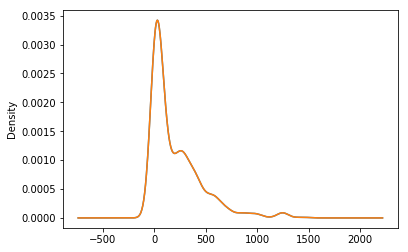

205.39638300230249
91.21733184317328
Uganda


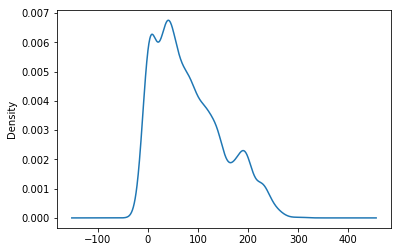

81.45626878072682
66.81789257254997
Ethiopia


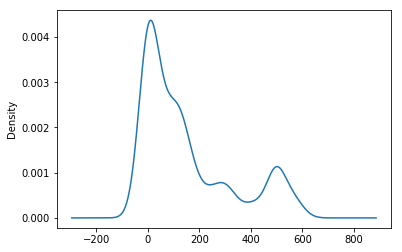

149.72028865288738
91.60891488879726
Sudan


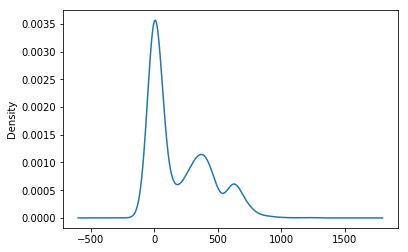

197.3108080269091
55.0
Burundi


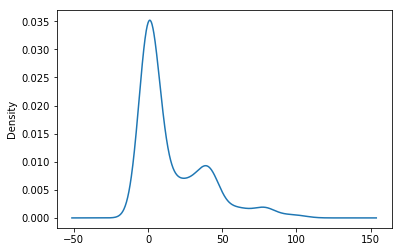

15.976187656922484
2.8241094171438212


In [323]:
for country in geoaid:
    print(country['NAME_0'].iloc[0])
    country_dist = pd.Series()
    for year in range(1999, 2009):
        country_dist = country_dist.append(plot_distances_new(year, country))
    
    
    country_dist.plot.density()
    plt.show()
    print(country_dist.mean())
    print(country_dist.median())